In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
%config InlineBackend.figure_format = 'retina'

In [2]:
G = 6.67e-11


ms = 1.989e30 #kg #sun
rs = 0 #m
theta_s = 0*np.pi/180
speed_fac_s = 1

mp1 = 1.898e27 #jupiter
rp1 = 7.49e11
theta_p1 = 0*np.pi/180
speed_fac_p1 = 1

mp2 = 5.683e26 #saturn
rp2 = 1.48e12
theta_p2 = 180*np.pi/180
speed_fac_p2 = 1

# y = np.array(mass, r, theta, x, y)
s = np.array((ms, rs, theta_s, rs*np.cos(theta_s), rs*np.sin(theta_s)))
p1 = np.array((mp1, rp1, theta_p1, rp1*np.cos(theta_p1), rp1*np.sin(theta_p1)))
p2 = np.array((mp2, rp2, theta_p2, rp2*np.cos(theta_p2), rp2*np.sin(theta_p2)))


data = np.row_stack((s,p1,p2))
#print(data)



In [3]:
def rand_m(lo=1e5,hi=1e10):
    m = np.random.random()*(hi-lo)+lo
    return m

def rand_theta(lo=1,hi=360):
    theta = np.random.random()*(hi-lo)+lo
    return theta

def rand_r(lo=3e11,hi=2e12):
    r = np.random.random()*(hi-lo)+lo
    return r


a_count = 10
for i in range(a_count):
    ma = rand_m()
    ra = rand_r()
    theta_a = rand_theta()*np.pi/180
#     print(ma,ra,theta_a)
    #(mass, r, theta, x, y)
    a = np.array((ma, ra, theta_a, ra*np.cos(theta_a), ra*np.sin(theta_a)))
    data = np.row_stack((data,a))

#print(data)
#print(np.shape(data))



In [4]:

xcm = (np.sum(data[:,0]*data[:,3]))/(np.sum(data[:,0]))
ycm = (np.sum(data[:,0]*data[:,4]))/(np.sum(data[:,0]))

# print(xcm,ycm)
# print(data)

data[:,3] += -xcm
data[:,4] += -ycm

xcm = (np.sum(data[:,0]*data[:,3]))/(np.sum(data[:,0]))
ycm = (np.sum(data[:,0]*data[:,4]))/(np.sum(data[:,0]))

# print(xcm,ycm)
# print(data)



In [5]:

length = np.shape(data)[0]

y_bar = []
for i in range(length):
    y_bar = np.append(y_bar,(data[i,3], data[i,4]))
    
# print(y_bar)  
#print(len(y_bar))


In [6]:
def dist(i,j):
    R = np.sqrt((data[i,3]-data[j,3])**2 + (data[i,4]-data[j,4])**2)
    return R

maxtheta_dot = 0
for i in range(data.shape[0]):
    theta_dot = 0
    for j in range(data.shape[0]):
        if (j != i):
            ri = np.sqrt((data[i,3])**2 + (data[i,4])**2)
            cos_term = np.cos(data[i,2] - np.arctan((data[j,4] - data[i,4])/(data[j,3] - data[i,3])))
            theta_dot += np.sqrt(np.abs(((G*data[j,0])/(ri*dist(i,j)**2))*cos_term))
            if (i == 2):
                maxtheta_dot = theta_dot
    #print(theta_dot)
    x_dot = -data[i,4]*theta_dot
    y_dot = data[i,3]*theta_dot

            #print(x_dot,y_dot)
    y_bar = np.append(y_bar,(x_dot,y_dot))

half_yb = len(y_bar)//2

y_bar[half_yb+1:half_yb+3]*=speed_fac_s
y_bar[half_yb+3:half_yb+5]*=speed_fac_p1
y_bar[half_yb+5:half_yb+7]*=speed_fac_p2
#print(half_yb)


In [7]:
 

def KeplerODE(t,y_bar):
    global data, G, half_yb
    
    y_bar_dot = np.copy(y_bar[half_yb:len(y_bar)+1])

    x_val = y_bar[0:half_yb+1:2]
    y_val = y_bar[1:half_yb+1:2]
    
    def dist_R(i,j):
        R = np.sqrt((x_val[i]-x_val[j])**2 + (y_val[i]-y_val[j])**2)
        return R 
#     print(len(x_val))                 
#     print(len(y_val)) 
#     print(data.shape[0])
#     print(len(y_bar_dot))
    
    for i in range(data.shape[0]):
        ax = 0
        ay = 0
        for j in range(data.shape[0]):
            if j!=i:
                rad_3 = dist_R(i,j)**3
                G_dat = -G*data[j,0]
                ax += (G_dat*(x_val[i] - x_val[j]))/rad_3
                ay += (G_dat*(y_val[i] - y_val[j]))/rad_3

                
        y_bar_dot = np.append(y_bar_dot,(ax,ay))
    return y_bar_dot        


In [8]:
orbits = 1
p=(2*np.pi)/maxtheta_dot #orbital period of the sun
steps = 4000
dt = p/1000
t=0

yts = []
xts = []

ytp1 = []
xtp1 = []

ytp2 = []
xtp2 = []

yta = []
xta = []

for i in range(steps*orbits):
    #print(i)    

    f1 = KeplerODE(t,y_bar)
#     print(y_bar)
#     print(f1)
    f2 = KeplerODE(t+dt/2,y_bar+(dt*f1)/2)
    f3 = KeplerODE(t+dt/2,y_bar+(dt*f2)/2)
    f4 = KeplerODE(t+dt,y_bar+dt*f3)

    y_bar = y_bar+(f1 + 2*f2 + 2*f3 + f4)*dt/6
    t = t+dt

    xts.append(y_bar[0])
    yts.append(y_bar[1])

    xtp1.append(y_bar[2])
    ytp1.append(y_bar[3])

    xtp2.append(y_bar[4])
    ytp2.append(y_bar[5])

    xta.append(y_bar[6:half_yb:2])
    yta.append(y_bar[7:half_yb+1:2])
    
    

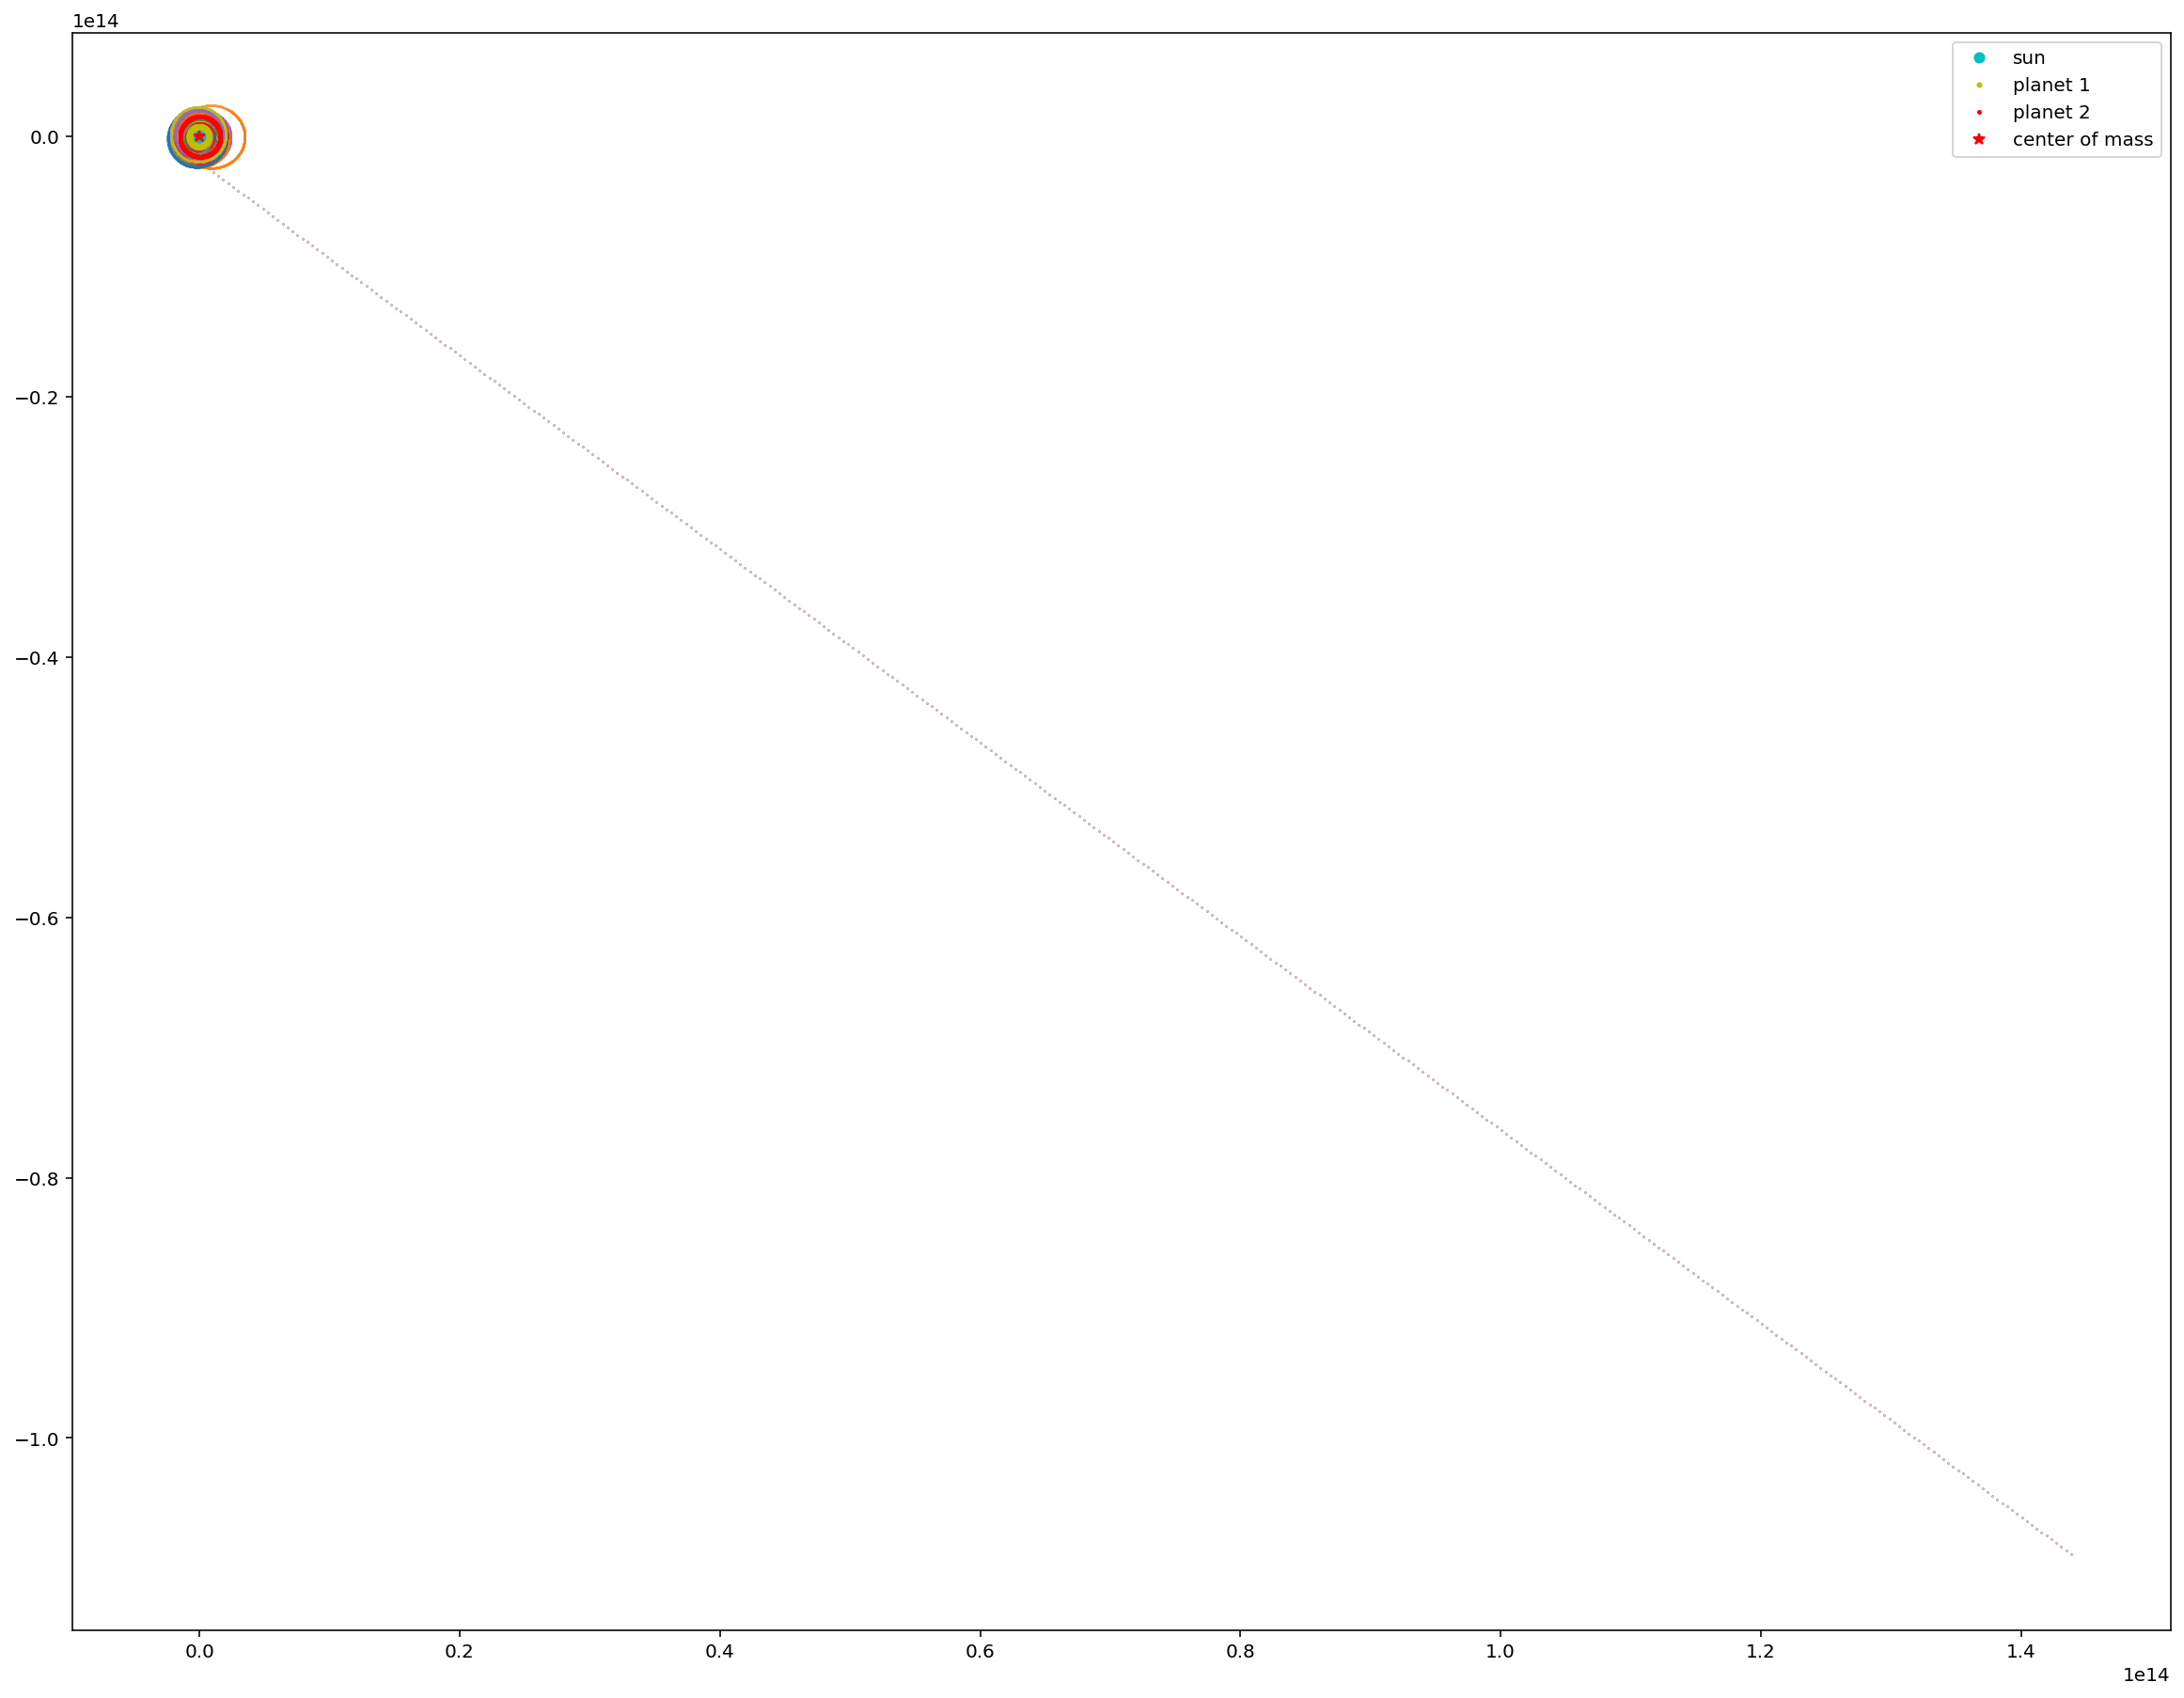

In [9]:
import matplotlib.axes as ax
plt.rcParams['figure.figsize'] = [20,20]

plt.plot(xta,yta,'.',markevery = 10,markersize = 0.5)
    
plt.plot(xts,yts,'co',markevery = 10,markersize = 5, label = 'sun')
plt.plot(xtp1,ytp1,'yo', markevery = 10,markersize = 2, label = 'planet 1')
plt.plot(xtp2,ytp2,'ro',markevery = 10, markersize = 1.5, label = 'planet 2')

plt.plot(0,0,'r*', label = 'center of mass')
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [ ]:
#The following code is only used to generate the animations.

In [10]:
%matplotlib osx
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Final Project animations', artist='HelenB',comment='Asteroid toss')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm 


In [11]:
with writer.saving(fig, "animation.mp4", dpi=200):

    for i in range (0,steps*orbits,30):
        
        if (i%100==0): print(i,end='')
        print('.',end='')

        fig.clear()

        plt.rcParams['figure.figsize'] = [10,10]

        #print(xts[0:i+1],yts[0:i+1])

        plt.plot(xta[0:i+1],yta[0:i+1],'.',markevery = 10, markersize = 0.5)
        plt.plot(xts[0:i+1],yts[0:i+1],'co',markevery = 10, markersize = 5)
        plt.plot(xtp1[0:i+1],ytp1[0:i+1],'yo',markevery = 10, markersize = 1.5)
        plt.plot(xtp2[0:i+1],ytp2[0:i+1],'ro',markevery = 10, markersize = 1)

        plt.plot(0,0,'r*')
        

        plt.gca().set_aspect('equal', adjustable='box')


        plt.draw()
        plt.show()
        plt.pause(0.01)
        writer.grab_frame()


0..........300..........600..........900..........1200..........1500..........1800..........2100..........2400..........2700..........3000..........3300..........3600..........3900....